In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
features = pd.read_csv("../../dataset/UCI_HAR/UCI HAR Dataset/features.txt", sep='\s+', header=None, names=['column_index', 'column_name'])
features_cc = features.groupby('column_name').cumcount()
features_cc = pd.DataFrame(features_cc)
features_cc.columns = ['cumcount']

In [3]:
features_df = pd.read_csv("../../dataset/UCI_HAR/UCI HAR Dataset/features.txt", sep='\s+', header=None, names=['column_index', 'column_name'])

# 피쳐이름에 그룹바이와 cumcount를 적용한 데이터프레임을 만든다
features_cc = features_df.groupby('column_name').cumcount() # (561, )의 시리즈 생성됨
features_cc = pd.DataFrame(features_cc) # (561, 1)의 데이터프레임으로 변환
features_cc.columns = ['cumcount'] # 칼럼명 추가
features_cc = features_cc.reset_index() # (561,2)가 된다.
features_df = features_df.reset_index() # (561,3)이 된다.

# 양쪽 데이터프레임 reset_index()의 결과로 생긴 'index'열을 기준으로 outer join(병합)한다.
# 그럼 결과적으로 index, column_index, column_name, cumcount 4개의 열을 가진 데이터프레임이 생성된다.
new_df = pd.merge(features_cc, features_df, on='index', how='outer')

# 병합에 사용되었던 index 칼럼을 드랍한다.
new_df = new_df.drop(['index'], axis=1) # column_index, column_name, cumcount의 (561,3)이 된다.

# column_name과 cumcount를 합쳐서 하나의 column_name으로 만드는 과정이다
# cumcount가 1이상일경우 column_name 뒤에 _1 또는 _2를 붙인다.
new_df['column_name'] = new_df[['column_name', 'cumcount']].apply(lambda x: x[0]+'_'+str(x[1])
                                                                if x[1]>0 else x[0], axis=1)

# cumcount를 column_name을 새로짓는 데 사용하였으므로 이제 드랍한다.
# 이 작업을 마치면 cumcount 칼럼이 없어져서 (561,2) 데이터프레임이 된다.
new_df = new_df.drop(['cumcount'], axis=1) # column_index, column_name 두개의 (561,2) 가 된다.

h = new_df['column_name'].value_counts()

for i in h:
    if (i == 3):
        print(False)

In [4]:
new_df['column_name'].values.shape

(561,)

In [5]:
X_train = pd.read_csv("../../dataset/UCI_HAR/UCI HAR Dataset/train/X_train.txt", header=None, sep="\s+", names=new_df['column_name'].values)
y_train = pd.read_csv("../../dataset/UCI_HAR/UCI HAR Dataset/train/y_train.txt", header=None, sep="\s+", names=['activity'])
X_test = pd.read_csv("../../dataset/UCI_HAR/UCI HAR Dataset/test/X_test.txt", header=None, sep="\s+", names=new_df['column_name'].values)
y_test = pd.read_csv("../../dataset/UCI_HAR/UCI HAR Dataset/test/y_test.txt", header=None, sep="\s+", names=['activity'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

scaled_X_train = pd.DataFrame(data=X_train, columns=new_df['column_name'].values)
scaled_X_test = pd.DataFrame(data=X_test, columns=new_df['column_name'].values)
scaled_X_train['label'] = y_train.values
scaled_X_test['label'] = y_test.values

scaled_X_train.shape, scaled_X_test.shape

((7352, 562), (2947, 562))

In [7]:
X_train_static = scaled_X_train[scaled_X_train['label'] > 3]
X_train_dynamic = scaled_X_train[scaled_X_train['label'] <= 3]
X_test_static = scaled_X_test[scaled_X_test['label'] > 3]
X_test_dynamic = scaled_X_test[scaled_X_test['label'] <= 3]

X_train_combined = scaled_X_train
X_test_combined = scaled_X_test

X_train_static.shape, X_train_dynamic.shape, X_test_static.shape, X_test_dynamic.shape, X_train_combined.shape, X_test_combined.shape

((4067, 562), (3285, 562), (1560, 562), (1387, 562), (7352, 562), (2947, 562))

In [8]:
y_train_static = X_train_static['label']
y_train_dynamic = X_train_dynamic['label']
y_train_combined = X_train_combined['label']
y_test_static = X_test_static['label']
y_test_dynamic = X_test_dynamic['label']
y_test_combined = X_test_combined['label']

X_train_static = X_train_static.drop('label', axis=1)
X_train_dynamic = X_train_dynamic.drop('label', axis=1)
X_train_combined = X_train_combined.drop('label', axis=1)
X_test_static = X_test_static.drop('label', axis=1)
X_test_dynamic = X_test_dynamic.drop('label', axis=1)
X_test_combined = X_test_combined.drop('label', axis=1)

In [9]:
X_train_static.shape, X_test_static.shape, X_train_dynamic.shape, X_test_dynamic.shape, X_train_combined.shape, X_test_combined.shape

((4067, 561), (1560, 561), (3285, 561), (1387, 561), (7352, 561), (2947, 561))

In [10]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 10
STEP = 1

In [11]:
X_train_static, y_train_static = create_dataset(X_train_static, y_train_static, TIME_STEPS, STEP)
X_train_dynamic, y_train_dynamic = create_dataset(X_train_dynamic, y_train_dynamic, TIME_STEPS, STEP)
X_train_combined, y_train_combined = create_dataset(X_train_combined, y_train_combined, TIME_STEPS, STEP)
X_test_static, y_test_static = create_dataset(X_test_static, y_test_static, TIME_STEPS, STEP)
X_test_dynamic, y_test_dynamic = create_dataset(X_test_dynamic, y_test_dynamic, TIME_STEPS, STEP)
X_test_combined, y_test_combined = create_dataset(X_test_combined, y_test_combined, TIME_STEPS, STEP)

X_train_static.shape, y_train_static.shape,

((4057, 10, 561), (4057, 1))

In [12]:
from sklearn.preprocessing import OneHotEncoder

enc_static = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_static = enc_static.fit(y_train_static)

enc_dynamic = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_dynamic = enc_dynamic.fit(y_train_dynamic)

enc_combined = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_combined = enc_combined.fit(y_train_combined)

y_train_static = enc_static.transform(y_train_static)
y_test_static = enc_static.transform(y_test_static)

y_train_dynamic = enc_dynamic.transform(y_train_dynamic)
y_test_dynamic = enc_dynamic.transform(y_test_dynamic)

y_train_combined = enc_combined.transform(y_train_combined)
y_test_combined = enc_combined.transform(y_test_combined)

/Users/kimtaeyoon/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kimtaeyoon/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kimtaeyoon/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
y_train_dynamic.shape

(3275, 3)

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [15]:
def model_LSTM(X_train_mod, y_train_mod):
    model = Sequential([
        LSTM(32, input_shape=(X_train_mod.shape[1], X_train_mod.shape[2])),
        Dropout(0.5),
        Dense(y_train_mod.shape[1], activation='softmax')
    ])

    return model

In [16]:
model_static = model_LSTM(X_train_static, y_train_static)
model_static.summary()

model_static.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                76032     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 76,131
Trainable params: 76,131
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_dynamic = model_LSTM(X_train_dynamic, y_train_dynamic)
model_dynamic.summary()

model_dynamic.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                76032     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 76,131
Trainable params: 76,131
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_combined = model_LSTM(X_train_combined, y_train_combined)
model_combined.summary()

model_combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                76032     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_static = model_static.fit(X_train_static, y_train_static, epochs=500, batch_size=32, validation_split=0.3)

Epoch 1/500
89/89 [==============================] - 3s 11ms/step - loss: 0.4554 - acc: 0.7985 - val_loss: 0.2809 - val_acc: 0.8941
Epoch 2/500
89/89 [==============================] - 0s 5ms/step - loss: 0.1923 - acc: 0.9288 - val_loss: 0.2029 - val_acc: 0.9204
Epoch 3/500
89/89 [==============================] - 1s 6ms/step - loss: 0.1086 - acc: 0.9644 - val_loss: 0.2374 - val_acc: 0.9195
Epoch 4/500
89/89 [==============================] - 0s 5ms/step - loss: 0.0847 - acc: 0.9729 - val_loss: 0.2067 - val_acc: 0.9319
Epoch 5/500
89/89 [==============================] - 0s 5ms/step - loss: 0.0696 - acc: 0.9785 - val_loss: 0.2103 - val_acc: 0.9286
Epoch 6/500
89/89 [==============================] - 0s 5ms/step - loss: 0.0759 - acc: 0.9743 - val_loss: 0.1537 - val_acc: 0.9442
Epoch 7/500
89/89 [==============================] - 0s 5ms/step - loss: 0.0529 - acc: 0.9838 - val_loss: 0.2521 - val_acc: 0.9327
Epoch 8/500
89/89 [==============================] - 0s 6ms/step - loss: 0.0496 - 

In [20]:
history_dynamic = model_dynamic.fit(X_train_dynamic, y_train_dynamic, epochs=500, batch_size=32, validation_split=0.3)

Epoch 1/500
72/72 [==============================] - 3s 19ms/step - loss: 0.5377 - acc: 0.7840 - val_loss: 0.2471 - val_acc: 0.9074
Epoch 2/500
72/72 [==============================] - 1s 9ms/step - loss: 0.2175 - acc: 0.9202 - val_loss: 0.2723 - val_acc: 0.9013
Epoch 3/500
72/72 [==============================] - 1s 12ms/step - loss: 0.1450 - acc: 0.9529 - val_loss: 0.2234 - val_acc: 0.9125
Epoch 4/500
72/72 [==============================] - 1s 12ms/step - loss: 0.1393 - acc: 0.9555 - val_loss: 0.2559 - val_acc: 0.9196
Epoch 5/500
72/72 [==============================] - 1s 10ms/step - loss: 0.1095 - acc: 0.9581 - val_loss: 0.2229 - val_acc: 0.9227
Epoch 6/500
72/72 [==============================] - 1s 11ms/step - loss: 0.1043 - acc: 0.9660 - val_loss: 0.2507 - val_acc: 0.9176
Epoch 7/500
72/72 [==============================] - 1s 12ms/step - loss: 0.0950 - acc: 0.9677 - val_loss: 0.3539 - val_acc: 0.9186
Epoch 8/500
72/72 [==============================] - 1s 15ms/step - loss: 0.0

In [21]:
history_combined = model_combined.fit(X_train_combined, y_train_combined, epochs=500, batch_size=32, validation_split=0.3)

Epoch 1/500
161/161 [==============================] - 4s 17ms/step - loss: 0.7066 - acc: 0.7667 - val_loss: 0.3442 - val_acc: 0.8997
Epoch 2/500
161/161 [==============================] - 2s 10ms/step - loss: 0.3042 - acc: 0.9187 - val_loss: 0.2681 - val_acc: 0.9115
Epoch 3/500
161/161 [==============================] - 2s 9ms/step - loss: 0.2078 - acc: 0.9438 - val_loss: 0.2414 - val_acc: 0.9206
Epoch 4/500
161/161 [==============================] - 2s 11ms/step - loss: 0.1639 - acc: 0.9550 - val_loss: 0.2571 - val_acc: 0.9160
Epoch 5/500
161/161 [==============================] - 2s 11ms/step - loss: 0.1226 - acc: 0.9693 - val_loss: 0.2210 - val_acc: 0.9296
Epoch 6/500
161/161 [==============================] - 2s 10ms/step - loss: 0.0991 - acc: 0.9731 - val_loss: 0.2107 - val_acc: 0.9337
Epoch 7/500
161/161 [==============================] - 2s 11ms/step - loss: 0.0864 - acc: 0.9778 - val_loss: 0.1940 - val_acc: 0.9405
Epoch 8/500
161/161 [==============================] - 2s 9ms/s

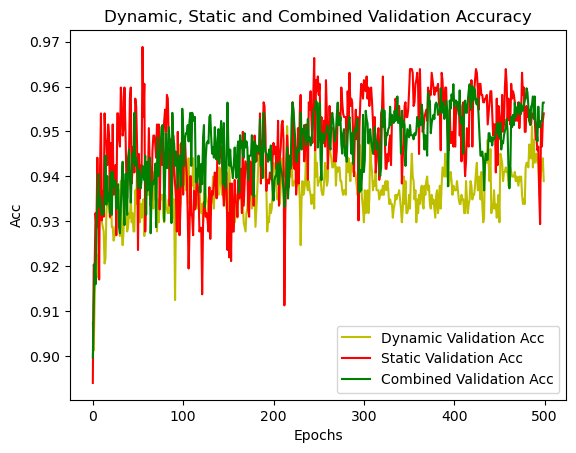

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

acc_static = history_static.history['acc']
val_acc_static = history_static.history['val_acc']

acc_dynamic = history_dynamic.history['acc']
val_acc_dynamic = history_dynamic.history['val_acc']

acc_combined = history_combined.history['acc']
val_acc_combined = history_combined.history['val_acc']

x = np.arange(0, 500)
plt.plot(x, val_acc_dynamic, 'y', label='Dynamic Validation Acc')
plt.plot(x, val_acc_static, 'r', label='Static Validation Acc')
plt.plot(x, val_acc_combined, 'g', label='Combined Validation Acc')
plt.title('Dynamic, Static and Combined Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

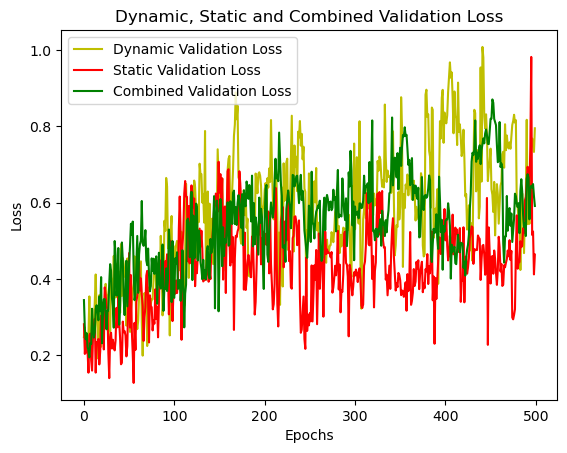

In [25]:
loss_static = history_static.history['loss']
val_loss_static = history_static.history['val_loss']

loss_dynamic = history_dynamic.history['loss']
val_loss_dynamic = history_dynamic.history['val_loss']

loss_combined = history_combined.history['loss']
val_loss_combined = history_combined.history['val_loss']

x = np.arange(0, 500)
plt.plot(x, val_loss_dynamic, 'y', label='Dynamic Validation Loss')
plt.plot(x, val_loss_static, 'r', label='Static Validation Loss')
plt.plot(x, val_loss_combined, 'g', label='Combined Validation Loss')
plt.title('Dynamic, Static and Combined Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
y_pred_static = model_static.predict(X_test_static)
y_pred_dynamic = model_dynamic.predict(X_test_dynamic)
y_pred_combined = model_combined.predict(X_test_combined)

92/92 [==============================] - 0s 2ms/step


In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_static_arg = np.argmax(y_test_static, axis=1)
y_test_dynamic_arg = np.argmax(y_test_dynamic, axis=1)
y_test_combined_arg = np.argmax(y_test_combined, axis=1)
Y_static_pred = np.argmax(model_static.predict(X_test_static), axis=1)
Y_dynamic_pred = np.argmax(model_dynamic.predict(X_test_dynamic), axis=1)
Y_combined_pred = np.argmax(model_combined.predict(X_test_combined), axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_static_arg, Y_static_pred))
print(confusion_matrix(y_test_dynamic_arg, Y_dynamic_pred))
print(confusion_matrix(y_test_combined_arg, Y_combined_pred))

92/92 [==============================] - 0s 2ms/step
Confusion Matrix
[[476  32   1]
 [ 23 502   2]
 [  0  12 502]]
[[499   3   7]
 [  7 464   2]
 [  4  52 339]]
[[507   0   7   0   0   0]
 [  0 475  11   0   2   0]
 [  5  45 345   0   2   0]
 [  0   0   0 483  26   0]
 [  0   1   0  27 482   0]
 [  2   0   0   1   0 516]]


In [29]:
score_static = model_static.evaluate(X_test_static, y_test_static)
score_dynamic = model_dynamic.evaluate(X_test_dynamic, y_test_dynamic)
score_combined = model_combined.evaluate(X_test_combined, y_test_combined)

pd.DataFrame(score_static)

92/92 [==============================] - 0s 2ms/step - loss: 0.5943 - acc: 0.9561


,0
0,0.414185
1,0.954839


In [30]:
pd.DataFrame(score_dynamic)

,0
0,0.624193
1,0.945534


In [31]:
pd.DataFrame(score_combined)

,0
0,0.594261
1,0.956078
